# Assignment 4: Wheres Waldo?
### Name: Eileanor LaRocco
In this assignment, you will develop an object detection algorithm to locate Waldo in a set of images. You will develop a model to detect the bounding box around Waldo. Your final task is to submit your predictions on Kaggle for evaluation.

Hello - I have worked on this for 8 days straight, spending close to 70 hours on this assignment at this point. Here is what completed including just a few of the many issues I encountered:

##### Data preprocessing:
First I examined the training images. I noticed that many of the images looked like the test images but a few did not. Additionally, a few images had multiple “Waldo” bounding boxes labeled in the annotations.csv.

I tried two main data preprocessing techniques:

1. Following the method in this paper (https://cs231n.stanford.edu/2024/papers/development-of-waldonet-a-novel-approach-to-solving-wheres-waldo.pdf) I first saved images of Waldo’s head to a folder using the annotations.csv. I then removed any that were too large, too few pixels to be useful, or did not look like how Waldo normally presents in the busy scenes (he tends to be facing sideways vs front-on). I then cropped each training image (only the ones with the busy background scenes) into 128x128 sections and randomly superimposed a random Waldo head onto each, saving new bounding box coordinates to a csv file. 
2. I thought that maybe 128x128 was too small of an image to learn on and then extrapolate to 1000-2000 pixel sized images (possibly why predictions on the test set were so far off). I also thought that maybe superimposing Waldo was not behaving as I thought. So for the second method I tried, I randomly cropped each training image (only the ones with the busy background scenes) into 512x512 pixel sections that all contained the full original waldo bounding boxes. This way waldo still presented as he normally does but his location is still different within each training image.

I then split the resulting images into training and testing sets and used them in the data loader code we were provided (although I did have to change part of it as my new annotations had different column indexes for the bounding box coordinates compared to the annotations folder we were provided. I then saved the training images with the bounding boxes overlayed so I could visually check that the new bounding boxes were correct (this was an issue for a bit as they weren’t resizing correctly and therefore our-of-bounds from the new image size).

Both processing techniques probably would have worked equally well, however, my model was not working properly and I thought that maybe it was because I superimposed Waldo without the background removed and that was what wasn’t allowing it to learn (it was not).

##### Model Building:
Where I spent the majority of the hours. I have no idea how we were supposed to go from implementing resnet50 from scratch to faster rcnn or yolo. It is a wild jump in understanding of both tensorflow and neural network architecture. I tried though.

From my understanding faster rcnn contains the following parts:
Resnet50 backbone to extract features from the input image
Regional Proposal Network (RPN) to propose the regions most likely to contain the waldo using anchor boxes with different scales and aspect ratios to do so so that waldo can be predicted no matter his size
Region of Interests (ROIs) - Classification (target vs background) and Regression (bounding boxes) pieces

I first tried a pretty simple neural network with 3 convolution layers. As you could assume, this did not perform very well as it was literally just a cnn that produced a tensor of 4 values for bounding box coordinates. The model did not learn anything while training - the validation iou stayed at 0 and even the training loss barely improved. I did think this was strange because after enough iterations even with a terrible model the training loss should decrease. Because of this I tried using PyTorch’s fasterrcnn_resnet50_fpn model to see if there was an issue with my training images. There was not - after just 10 epochs the PyTorch model was able to find waldo in one of the test images. So from there the only option left was to create a faster rcnn model from scratch. I tried many ways to implement this and ended up debugging so so many errors. Either the model worked on a random test input tensor but did not work within my training/evaluation loop or it didn’t work at all. A large part of the issues revolved around computing the training loss and generally trianing/testing the model without tensor errors.

I finally got a small rcnn version working that I believe holds most of the important parts of rcnn even if not all fully implemented correctly or optimally. It performs not great on the valiadation set and obviously even worse on the test set - therefore creating my 0.000 iou value on kaggle. That value should be easily reproducible through this notebook.

##### Training/Evaluation:
I created a training and testing loop to train the model. For the training function I set it up to calculate loss given the image and target within the training loop. For the evaluation function I set it up to calculate iou as that is what the Kaggle competition is training on and I wanted to save the model with the best iou score. I originally set up the training and testing loop to assume an input similar to the faster rccn model in PyTorch with output of bounding boxes, labels, and scores for each image. This created a lot of errors when I tried to use my own model with this training loop as my model did not include a loss function calculated in the forward pass as the faster rcnn PyTorch model does. So I had to re-do the training/testing loop.

I testing different values for the learning rate, scheduler, and batch size.

##### Predictions:
Given that the images I trained on were of the same size (512x512) and the images we were given to test on were larger and of differing sizes, I transformed the test images similarly (resizing and normalizing) and once predicting the bounding boxes given the model (predicting on the resized images) I had to transform the predicted bounding boxes to scale back to the original test image size. I then saved each annotation and file name to the csv to create the submission file and saved the test images with the bounding boxes drawn on them to check the predictions visually. I have a hunch that this large rescaling is part of why the model performs so much worse on the test set than the validation set even when the model is not overfit.

### Imports

In [1]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
#!pip install opencv-python
import cv2

import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

In [2]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = device = torch.device("cuda")
print(device)

cuda


### Download Data

In [4]:
od.download('https://www.kaggle.com/competitions/2024-fall-ml-3-hw-4-wheres-waldo/data')

Skipping, found downloaded files in "./2024-fall-ml-3-hw-4-wheres-waldo" (use force=True to force download)


In [5]:
train_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/train" # Original Train Images
test_folder = "2024-fall-ml-3-hw-4-wheres-waldo/test/test" # Original Test Images
annotations_file = "2024-fall-ml-3-hw-4-wheres-waldo/annotations.csv" # Original Annotations File

# Data Augmentation

In [6]:
image_sz = 512

### Draw bounding boxes on each training image to check accuracy

In [11]:
# Paths
output_folder = "2024-fall-ml-3-hw-4-wheres-waldo/checks"  # Folder to save images with drawn boxes

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Read the CSV file
# Assumes the CSV columns are: filename, xmin, ymin, xmax, ymax
annotations = pd.read_csv(annotations_file)

# Iterate through each image in the annotations
for _, row in annotations.iterrows():
    image_name = row["filename"]
    x_min, y_min, x_max, y_max = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
    
    # Load the image
    image_path = os.path.join(train_folder, image_name)
    if not os.path.exists(image_path):
        print(f"Image {image_path} not found. Skipping...")
        continue
    image = cv2.imread(image_path)
    
    # Draw the bounding box
    # cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (B, G, R), thickness)
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 4)
    
    # Optionally, add a label or text
    label = "Waldo"
    cv2.putText(image, label, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Save the image
    output_path = os.path.join(output_folder, image_name)
    cv2.imwrite(output_path, image)

    print(f"Annotated image saved to {output_path}")

print("All bounding boxes have been drawn and saved.")

Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/1.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/10.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/11.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/12.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/13.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/14.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/15.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/17.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/18.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/19.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/2.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/3.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/4.jpg
Annotated image saved to 2024-fall-ml-3-hw-4-wheres-waldo/checks/5.j

In [12]:
### Remove training images that don't include waldo as he appears in test images
#16,22-27 do not include waldo in a background, 8 and 10 include waldo in the postcard

def delete_files_from_list(folder_path, file_names_to_delete):
    """Deletes files in the given folder if their name is in the provided list."""

    for filename in os.listdir(folder_path):
        if filename in file_names_to_delete:
            file_path = os.path.join(folder_path, filename)
            os.remove(file_path)
            print(f"Deleted: {file_path}")

if __name__ == "__main__":
    folder_path =  "2024-fall-ml-3-hw-4-wheres-waldo/train/train"
    file_names_to_delete = ["8.jpg", "10.jpg", "16.jpg", "22.jpg", "23.jpg", "24.jpg", "25.jpg", "26.jpg", "27.jpg"]
    delete_files_from_list(folder_path, file_names_to_delete)
    
# Remove associated annotations
df = pd.read_csv(annotations_file)

# Keep rows where the value in column 'filename' is not in the list
df = df[~df['filename'].isin(file_names_to_delete)]
df.to_csv(annotations_file, index=False)

Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/24.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/22.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/10.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/27.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/25.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/8.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/23.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/16.jpg
Deleted: 2024-fall-ml-3-hw-4-wheres-waldo/train/train/26.jpg


In [29]:
# Check size of Train Images

# Iterate over all images in the folder
for image_name in os.listdir(train_folder):
    if image_name.endswith((".jpg")):
        image_path = os.path.join(train_folder, image_name)
        
        # Read the image using OpenCV
        img = cv2.imread(image_path)
        if img is not None:
            height, width, channels = img.shape  # Get image size (height, width, channels)
            print(f"Image: {image_name}, Width: {width}, Height: {height}")
        else:
            print(f"Could not read image: {image_name}")

#Image 27 includes waldo 6 times, 10 2 times, 8 2 times
#16,22-27 do not include waldo in a background

Image: 17.jpg, Width: 1599, Height: 1230
Image: 6.jpg, Width: 2048, Height: 1454
Image: 15.jpg, Width: 1600, Height: 1006
Image: 1.jpg, Width: 2048, Height: 1251
Image: 13.jpg, Width: 1280, Height: 864
Image: 4.jpg, Width: 2048, Height: 1272
Image: 7.jpg, Width: 1949, Height: 1419
Image: 20.jpg, Width: 2953, Height: 2088
Image: 18.jpg, Width: 1590, Height: 981
Image: 2.jpg, Width: 1286, Height: 946
Image: 21.jpg, Width: 2048, Height: 1515
Image: 19.jpg, Width: 1280, Height: 864
Image: 11.jpg, Width: 2828, Height: 1828
Image: 14.jpg, Width: 1700, Height: 2340
Image: 5.jpg, Width: 2100, Height: 1760
Image: 12.jpg, Width: 1276, Height: 1754
Image: 9.jpg, Width: 1298, Height: 951
Image: 3.jpg, Width: 2048, Height: 1346


In [13]:
# Create more training data - randomly crop 512x512 sections where full waldo bounding box exists

import os
import pandas as pd
import csv
import random
from PIL import Image

def generate_crops(train_folder, annotations_file, output_folder, output_csv, crop_size=512, num_crops=5):
    # Ensure the output folder exists - if not, make it
    os.makedirs(output_folder, exist_ok=True)
    
    # Load annotations
    annotations = pd.read_csv(annotations_file)
    
    new_annotations = []
    
    for _, row in annotations.iterrows():
        img_path = os.path.join(train_folder, row['filename'])
        image = Image.open(img_path)
        width, height = image.size
        
        x_min, y_min, x_max, y_max = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        
        for i in range(num_crops):
            # Generate random crop coordinates
            crop_x_min = max(0, random.randint(x_min - crop_size, x_min))
            crop_y_min = max(0, random.randint(y_min - crop_size, y_min))
            crop_x_max = min(crop_x_min + crop_size, width)
            crop_y_max = min(crop_y_min + crop_size, height)
            
            # Adjust crop to ensure it's exactly crop_size x crop_size
            if crop_x_max - crop_x_min < crop_size:
                crop_x_min = max(0, crop_x_max - crop_size)
            if crop_y_max - crop_y_min < crop_size:
                crop_y_min = max(0, crop_y_max - crop_size)
            
            # Ensure Waldo is fully included in the crop
            if not (crop_x_min <= x_min and crop_x_max >= x_max and crop_y_min <= y_min and crop_y_max >= y_max):
                continue
            
            # Crop the image
            cropped_image = image.crop((crop_x_min, crop_y_min, crop_x_max, crop_y_max))
            
            # Save the cropped image
            new_filename = f"{os.path.splitext(row['filename'])[0]}_crop_{i}.jpg"
            cropped_image.save(os.path.join(output_folder, new_filename))
            
            # Calculate the new bounding box coordinates
            new_x_min = x_min - crop_x_min
            new_y_min = y_min - crop_y_min
            new_x_max = x_max - crop_x_min
            new_y_max = y_max - crop_y_min
            
            # Add to new annotations
            new_annotations.append({
                "filename": new_filename,
                "xmin": new_x_min,
                "ymin": new_y_min,
                "xmax": new_x_max,
                "ymax": new_y_max
            })
    
    # Save new annotations to CSV
    new_annotations_df = pd.DataFrame(new_annotations)
    new_annotations_df.to_csv(output_csv, index=False)
    print(f"Generated crops saved to {output_folder}. New annotations saved to {output_csv}.")

# Define the paths
output_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/chunks"
output_csv = "2024-fall-ml-3-hw-4-wheres-waldo/chunks_annotations.csv"
crop_size = 512
num_crops = 60

#Use function
generate_crops(train_folder, annotations_file, output_folder, output_csv, crop_size, num_crops)


Generated crops saved to 2024-fall-ml-3-hw-4-wheres-waldo/train/chunks. New annotations saved to 2024-fall-ml-3-hw-4-wheres-waldo/chunks_annotations.csv.


### Train/Test Split

In [16]:
# Split training data into train and validation sets
annotations = pd.read_csv("2024-fall-ml-3-hw-4-wheres-waldo/chunks_annotations.csv")
image_files = annotations["filename"].unique()
train_images, val_images = train_test_split(image_files, test_size=0.2, random_state=42)

def filter_csv_by_column(input_csv, output_csv, column_name, values_list):

    # Load the CSV into a DataFrame
    df = pd.read_csv(input_csv)

    # Filter the DataFrame
    filtered_df = df[df[column_name].isin(values_list)]

    # Save the filtered DataFrame to a new CSV file
    filtered_df.to_csv(output_csv, index=False)

#Train Annotations
values_list = list(train_images)
output_csv = "2024-fall-ml-3-hw-4-wheres-waldo/train_annotations.csv"
column_name = "filename"
filter_csv_by_column("2024-fall-ml-3-hw-4-wheres-waldo/chunks_annotations.csv", output_csv, column_name, values_list)

#Test Annotations
values_list = list(val_images)
output_csv = "2024-fall-ml-3-hw-4-wheres-waldo/test_annotations.csv"
column_name = "filename"
filter_csv_by_column("2024-fall-ml-3-hw-4-wheres-waldo/chunks_annotations.csv", output_csv, column_name, values_list)

#Train/Test Split (80/20)
def split_directory(source_dir, target_dir, file_list):
    """Splits files from source_dir to target_dir based on file_list."""

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for file_name in file_list:
        source_path = os.path.join(source_dir, file_name)
        target_path = os.path.join(target_dir, file_name)

        if os.path.exists(source_path):
            shutil.move(source_path, target_path)
            #print(f"Moved: {file_name}")
        else:
            print(f"File not found: {file_name}")

if __name__ == "__main__":
    source_dir = "2024-fall-ml-3-hw-4-wheres-waldo/train/chunks"
    target_dir = "2024-fall-ml-3-hw-4-wheres-waldo/train/val"
    file_list = list(val_images)

    split_directory(source_dir, target_dir, file_list)

# Train and Test Loaders

In [30]:
# Define the dataset (Train and Test Loaders)
class WaldoDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        #image = torchvision.transforms.ToTensor()(image)  # Convert to tensor
        
        box_data = self.img_labels.iloc[idx, 1:].values
        boxes = [float(item) for item in box_data]
        
        boxes = torch.as_tensor([boxes], dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target


# Set up the dataset and data loaders
train_dataset = WaldoDataset(
    annotations_file="2024-fall-ml-3-hw-4-wheres-waldo/train_annotations.csv",
    img_dir="2024-fall-ml-3-hw-4-wheres-waldo/train/chunks",
    transforms=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_sz, image_sz)), #does this resize the bounding box too?
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

val_dataset = WaldoDataset(
    annotations_file="2024-fall-ml-3-hw-4-wheres-waldo/test_annotations.csv",
    img_dir="2024-fall-ml-3-hw-4-wheres-waldo/train/val",
    transforms=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_sz, image_sz)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=lambda x: list(zip(*x))
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=lambda x: list(zip(*x))
)


# Model

### Architecture

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.ops import RoIAlign
import torchvision.ops as ops

def decode_boxes(deltas, anchors):
    # Convert anchors to center format (cx, cy, w, h)
    anchors = ops.box_convert(anchors, in_fmt="xyxy", out_fmt="cxcywh")
    anchor_cx, anchor_cy, anchor_w, anchor_h = anchors.split(1, dim=1)

    # Decode deltas
    dx, dy, dw, dh = deltas.split(1, dim=1)
    pred_cx = dx * anchor_w + anchor_cx
    pred_cy = dy * anchor_h + anchor_cy
    pred_w = torch.exp(dw) * anchor_w
    pred_h = torch.exp(dh) * anchor_h

    # Convert back to (x1, y1, x2, y2)
    decoded_boxes = torch.cat([
        pred_cx - 0.5 * pred_w,  # x1
        pred_cy - 0.5 * pred_h,  # y1
        pred_cx + 0.5 * pred_w,  # x2
        pred_cy + 0.5 * pred_h   # y2
    ], dim=1)

    return decoded_boxes


def generate_anchors(base_size, scales, aspect_ratios, feature_size, stride, device):
    anchors = []
    for y in range(feature_size[0]):
        for x in range(feature_size[1]):
            cx = x * stride + stride / 2  # Center x
            cy = y * stride + stride / 2  # Center y
            for scale in scales:
                for ratio in aspect_ratios:
                    w = base_size * scale * (ratio ** 0.5)
                    h = base_size * scale / (ratio ** 0.5)
                    anchors.append([cx - w / 2, cy - h / 2, cx + w / 2, cy + h / 2])
    anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
    return anchors


def generate_proposals(rpn_cls_logits, rpn_bbox_preds, anchors, image_size, device, top_n=1):
    batch_size = rpn_cls_logits.size(0)
    proposals = []

    for b in range(batch_size):
        # Flatten predictions and anchors
        cls_logits = rpn_cls_logits[b].permute(1, 2, 0).reshape(-1, 2)
        bbox_preds = rpn_bbox_preds[b].permute(1, 2, 0).reshape(-1, 4)
        
        # Apply softmax to classification logits
        scores = F.softmax(cls_logits, dim=-1)[:, 1] 
        
        # Decode predicted deltas to proposals
        decoded_boxes = decode_boxes(bbox_preds, anchors)
        
        # Clip proposals to image boundaries
        decoded_boxes = ops.clip_boxes_to_image(decoded_boxes, image_size)
        
        # Filter proposals by score and apply NMS
        keep = ops.nms(decoded_boxes, scores, iou_threshold=0.7)
        keep = keep[:top_n]  # Keep top_n proposals (1 in this case)
        
        # Add batch index
        batch_proposals = torch.cat(
            [torch.full((len(keep), 1), b, dtype=torch.float32, device=decoded_boxes.device), 
             decoded_boxes[keep]], 
            dim=1
        )
        proposals.append(batch_proposals)

    # Concatenate all proposals across batches
    return torch.cat(proposals, dim=0)


class SimpleRCNN(nn.Module):
    def __init__(self, num_anchors=9):
        super(SimpleRCNN, self).__init__()
        
        # Use pretrained ResNet50 as the backbone
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Use layers up to the last conv layer
        
        # Freeze the initial layers to retain pretrained weights
        for param in list(self.backbone.parameters())[:4]:  # Freeze
            param.requires_grad = False

        # Region Proposal Network (RPN)
        self.rpn_conv = nn.Conv2d(2048, 512, kernel_size=3, padding=1)  # RPN Conv layer
        self.rpn_cls = nn.Conv2d(512, num_anchors * 2, kernel_size=1)  # 2 class logits per anchor (object, no object)
        self.rpn_reg = nn.Conv2d(512, num_anchors * 4, kernel_size=1)  # 4 bbox coords per anchor

        # RoI Align (assumes a fixed feature map size of 7x7 for simplicity)
        self.roi_align = RoIAlign((7, 7), spatial_scale=1.0 / 16, sampling_ratio=2)

        # Fully connected layers for classification and regression
        self.fc1 = nn.Linear(2048 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 4)  # Output bbox coords (x, y, w, h)

    def forward(self, x):
        # Extract features
        features = self.backbone(x)

        # Generate RPN outputs
        rpn_feat = F.relu(self.rpn_conv(features))
        rpn_cls_logits = self.rpn_cls(rpn_feat)
        rpn_bbox_preds = self.rpn_reg(rpn_feat)

        # Generate anchors
        feature_size = (features.size(2), features.size(3))  # (height, width) of feature map
        stride = 16  # Assuming input image is downsampled by 16x in the backbone
        anchors = generate_anchors(base_size=16, scales=[1.0, 2.0, 0.5], aspect_ratios=[0.5, 1.0, 2.0],
                                    feature_size=feature_size, stride=stride, device=x.device)

        # Generate proposals from RPN outputs
        proposals = generate_proposals(rpn_cls_logits, rpn_bbox_preds, anchors, x.size()[2:], device=x.device, top_n=1)

        # Perform RoI Align
        roi_features = self.roi_align(features, proposals)

        # Predict bounding boxes
        roi_flattened = roi_features.view(roi_features.size(0), -1)
        fc1_out = F.relu(self.fc1(roi_flattened))
        bbox = self.fc2(fc1_out)

        return bbox


# Example usage:
# Instantiate the model
model = SimpleRCNN()

# Example input image tensor (batch_size=1, channels=3, height=512, width=512)
input_tensor = torch.randn(1, 3, 512, 512)

# Move inputs to the same device as the model
model = model.to(device)
input_tensor = input_tensor.to(device)

# Forward pass
bbox = model(input_tensor)

print("BBox Refinements:", bbox.shape)
print(bbox)


BBox Refinements: torch.Size([1, 4])
tensor([[ 0.0973, -0.0978,  0.1104, -0.0034]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


### Training

In [21]:
checkpoint_path = "2024-fall-ml-3-hw-4-wheres-waldo/outputs/best_model.pth"

if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)

In [32]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn


def calculate_iou(pred_boxes, target_boxes):
    """
    Compute IoU between predicted and target bounding boxes.
    Args:
        pred_boxes: Tensor of shape (N, 4) with predicted boxes (x_min, y_min, x_max, y_max).
        target_boxes: Tensor of shape (N, 4) with ground truth boxes (x_min, y_min, x_max, y_max).
    Returns:
        IoU: Tensor of shape (N,) with IoU scores for each box.
    """
    # Resize Target Boxes
    target_boxes = target_boxes.squeeze(1)

    # Calculate intersection
    x_min_inter = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
    y_min_inter = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
    x_max_inter = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
    y_max_inter = torch.min(pred_boxes[:, 3], target_boxes[:, 3])

    inter_area = torch.clamp(x_max_inter - x_min_inter, min=0) * torch.clamp(y_max_inter - y_min_inter, min=0)

    # Calculate union
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    target_area = (target_boxes[:, 2] - target_boxes[:, 0]) * (target_boxes[:, 3] - target_boxes[:, 1])
    union_area = pred_area + target_area - inter_area

    # Compute IoU
    iou = inter_area / torch.clamp(union_area, min=1e-6)  # Avoid division by zero
    return iou


def train(model, train_data_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    total_iou = 0.0
    num_samples = 0

    for images, targets in train_data_loader:
        
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
        
        # Extract bounding boxes from targets
        target_boxes = torch.stack([target["boxes"] for target in targets]).squeeze(1)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(torch.stack(images))

        # Calculate the loss
        loss = criterion(outputs, target_boxes)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate IoU
        iou = calculate_iou(outputs, target_boxes)
        total_iou += iou.sum().item()
        num_samples += len(target_boxes)

    avg_loss = running_loss / len(train_data_loader)
    avg_iou = total_iou / num_samples

    #print(f"Training Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")


def evaluate(model, val_data_loader, criterion, checkpoint_path):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, targets in val_data_loader:
            
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
            
            # Extract bounding boxes from targets
            target_boxes = torch.stack([target["boxes"] for target in targets]).squeeze(1)

            # Forward pass
            outputs = model(torch.stack(images))

            # Calculate the loss
            loss = criterion(outputs, target_boxes)
            total_loss += loss.item()

            # Calculate IoU
            iou = calculate_iou(outputs, target_boxes)
            total_iou += iou.sum().item()
            num_samples += len(target_boxes)

    avg_loss = total_loss / len(val_data_loader)
    avg_iou = total_iou / num_samples
    

    #print(f"Evaluation Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")
    return avg_iou
    
    
# Set up the model, loss, and optimizer
model = SimpleRCNN().to(device)
criterion = nn.L1Loss()  # L1 loss for bounding box regression
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs = 100
best_iou = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Train the model
    train(model, train_data_loader, criterion, optimizer)

    # Evaluate the model
    avg_iou = evaluate(model, val_data_loader, criterion, checkpoint_path)
    
    #Scheduler
    scheduler.step()
    
    # Save the best model
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Best model saved with IoU: {best_iou:.4f}")



Epoch 1/100
Best model saved with IoU: 0.0005
Epoch 2/100
Best model saved with IoU: 0.0060
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Best model saved with IoU: 0.0063
Epoch 7/100
Best model saved with IoU: 0.0089
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Best model saved with IoU: 0.0090
Epoch 14/100
Epoch 15/100
Best model saved with IoU: 0.0103
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Best model saved with IoU: 0.0105
Epoch 35/100
Best model saved with IoU: 0.0157
Epoch 36/100
Best model saved with IoU: 0.0160
Epoch 37/100
Epoch 38/100
Best model saved with IoU: 0.0253
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Best m

# Predictions and Submission File 

In [33]:
#Load saved best model
model = SimpleRCNN().to(device)
model.load_state_dict(torch.load('2024-fall-ml-3-hw-4-wheres-waldo/outputs/best_model.pth'))

/tmp/ipykernel_650430/111478041.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('2024-fall-ml-3-hw-4-wheres-waldo/outputs/best_model.pth

<All keys matched successfully>

Predicted Bounding Box: [369.20132 171.964   408.43628 216.06364]


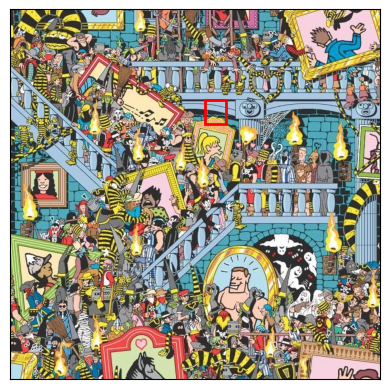

Predicted Bounding Box: [408.62878 368.0724  450.33795 411.06815]


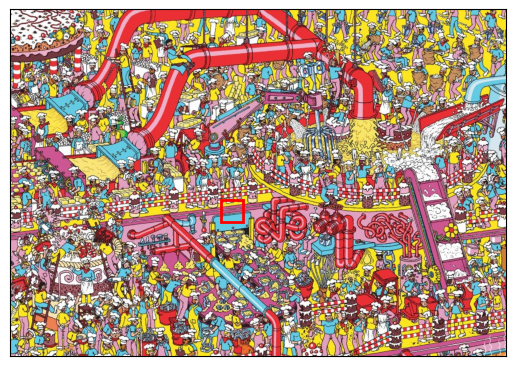

Predicted Bounding Box: [332.79846 252.07112 367.7639  292.3509 ]


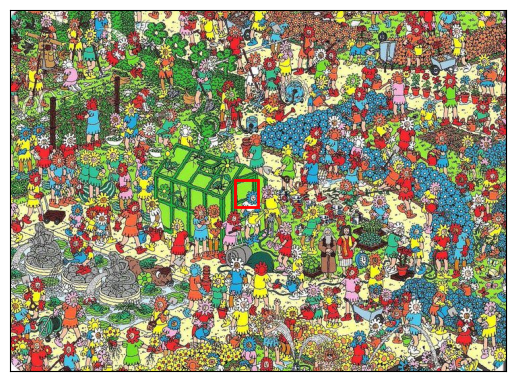

Predicted Bounding Box: [303.85928 253.03723 327.66177 293.87564]


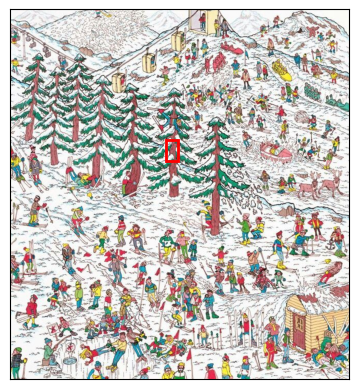

Predicted Bounding Box: [648.57776 621.87274 705.18304 677.0672 ]


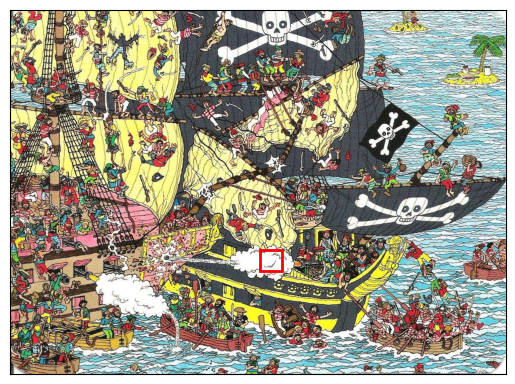

Predicted Bounding Box: [1196.3073   651.6178  1298.1781   733.61035]


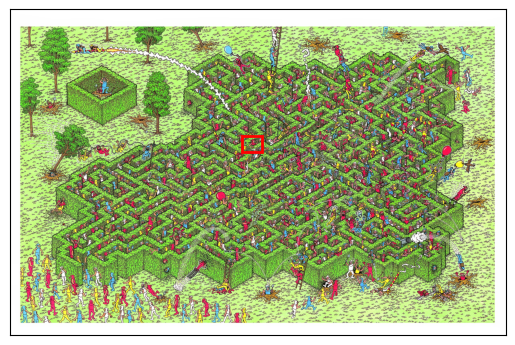

Predicted Bounding Box: [246.10608 168.92056 279.62677 200.21587]


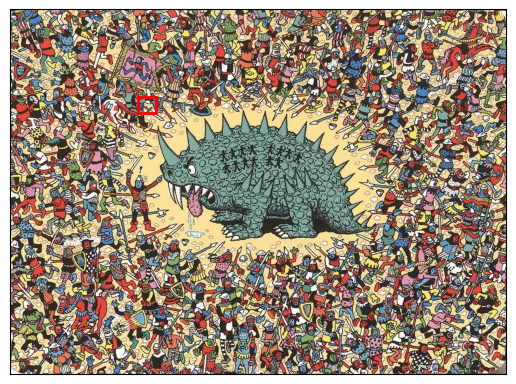

Predicted Bounding Box: [358.49768 272.75217 397.7149  314.34943]


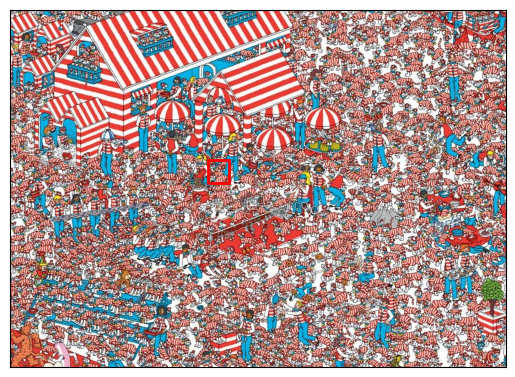

Predicted Bounding Box: [ 978.0975   535.45496 1047.5459   585.01624]


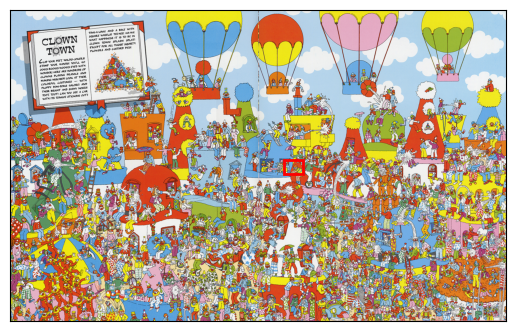

In [34]:
predictions = []

output_directory = "2024-fall-ml-3-hw-4-wheres-waldo/outputs"
if not os.path.exists(output_directory):
        os.makedirs(output_directory)

# Function to predict bounding box on a new image
def predict(model, image_path, transform=None):
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    orig_width, orig_height = image.size  # Get original image dimensions
    if transform:
        image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension

    # Ensure image is a Tensor and move it to the correct device
    image = image.to(device)

    # Predict the bounding box
    with torch.no_grad():
        predicted_bbox = model(image).squeeze().cpu().numpy()

    # Scale bbox back to original image dimensions
    predicted_bbox[0] *= orig_width / image_sz  # x_min
    predicted_bbox[1] *= orig_height / image_sz  # y_min
    predicted_bbox[2] *= orig_width / image_sz  # x_max
    predicted_bbox[3] *= orig_height / image_sz  # y_max

    return predicted_bbox


# Define image transformations (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((image_sz, image_sz)),  # Resize the image to 512x512
    transforms.ToTensor(),  # Convert the image to a tensor
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#For each image in test folder, predict, draw bounding box, save image, and save into csv file for submission
test_images = [img for img in os.listdir(test_folder) if img.endswith(".jpg")]
predictions = []

for name in test_images:
    image_path = os.path.join(test_folder, name) 
    predicted_bbox = predict(model, image_path, transform)

    # Print the predicted bounding box (x_min, y_min, x_max, y_max)
    print("Predicted Bounding Box:", predicted_bbox)

    # Plot the image and the predicted bounding box
    image = Image.open(image_path)
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle(
        (predicted_bbox[0], predicted_bbox[1]),  # (x_min, y_min)
        predicted_bbox[2] - predicted_bbox[0],  # Width (x_max - x_min)
        predicted_bbox[3] - predicted_bbox[1],  # Height (y_max - y_min)
        linewidth=2, edgecolor='r', facecolor='none'
    ))
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(output_directory, name), bbox_inches='tight')
    plt.show()

    # Extract bounding box coordinates
    x_min, y_min, x_max, y_max = predicted_bbox
    predictions.append([name, x_min, y_min, x_max, y_max])

# Save predictions to CSV
df = pd.DataFrame(predictions, columns=["filename", "xmin", "ymin", "xmax", "ymax"])
df.to_csv(os.path.join(output_directory, 'predictions.csv'), index=False)
